In [1]:
import os
path="/content/drive/My Drive/Colab Notebooks/Pytorch Name Classifier"
os. chdir(path)

In [2]:
# References
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/pytorch_basics/main.py
# http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class
import torch
import numpy as np
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import csv
import gzip
import unicodedata

class NameDataset(Dataset):
    """ Diabetes dataset."""

    # Initialize your data, download, etc.
    def __init__(self, is_train_set=False):
        filename = './Data2/namedata_train.csv' if is_train_set else './Data2/namedata_test.csv'
        with open(filename, "r", encoding='mac_roman') as f:
            reader = csv.reader(f)
            rows = list(reader)
        names = [row[0] for row in rows]
        self.names = [self.remove_accents(x) for x in names]
        self.countries = [row[1] for row in rows]
        self.len = len(self.countries)
        self.country_list = list(sorted(set(self.countries)))

        _, country_counts = np.unique(self.countries, return_counts=True)
        self.samplingweights = 1/country_counts #Weighted sampling, 1/frequency

    def remove_accents(self, input_str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    def __getitem__(self, index):
        return self.names[index], self.countries[index]

    def __len__(self):
        return self.len

    def get_countries(self):
        return self.country_list

    def get_country(self, id):
        return self.country_list[id]

    def get_country_id(self, country):
        return self.country_list.index(country)

    def get_weights(self):
        return self.samplingweights

# Test the loader
if __name__ == "__main__":
    dataset = NameDataset(True)
    print(dataset.get_countries())
    print(dataset.get_country(3))
    print(dataset.get_country_id('Korean'))

    weights = dataset.get_weights()
    target_list = torch.tensor([dataset.get_country_id(x) for x in list(dataset.countries)])
    target_list = target_list[torch.randperm(len(target_list))]
    class_weights_all = weights[target_list]

    sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all,num_samples=len(class_weights_all))

    train_loader = DataLoader(dataset=dataset,
                              batch_size=256,
                              sampler=sampler)

    print(len(train_loader.dataset))
    for epoch in range(2):
        for i, (names, countries) in enumerate(train_loader):
            # Run your training process
            print(epoch, i, "names", names, "countries", countries)

['British', 'Burmese', 'Chinese', 'Czech', 'Dutch', 'Ethiopian', 'French', 'German', 'Greek', 'Indian', 'Indonesian', 'Italian', 'Japanese', 'Korean', 'Middle_eastern', 'Polish', 'Spanish_portugese_hispanic', 'Swedish', 'Thai', 'Turkish', 'Vietnamese', 'West_african']
Czech
13
15131
0 0 names ('Ko_ar', 'Samuel', 'Botros', 'Mclean', 'Kong', 'Guyen', 'Parent', 'Alcaraz', 'Snider', 'Santoso', 'Bologna', 'Cerv', 'Kinugasa', 'Masudu', 'Chinuang', "O'Brian", 'Sertkaya', 'Christy', 'Swain', 'Syamsudin', 'Aryanto', 'Quyen', 'Malouf', 'Abdollahzadeh', 'Gravari', 'Kanak', 'Moghadam', 'Kim', 'Khouri', 'Rose', 'Wirner', 'Griffiths', 'Shakespeare', 'Roach', 'Arishima', 'Franco', 'Fujimoto', 'Rossini', 'Leadley', 'Griffiths', 'Fallahi', 'Lacroix', 'Anderton', 'Srour', 'Mathew', 'Almgren', 'Reade', 'Leonard', 'Santiz', 'Taylor', 'Tekeli', 'Stamatelos', 'Isa', 'Munsan', 'Schwarzenberg', 'Keight', 'Stumpf', 'Oskarsson', 'Amani', 'Bassani', 'Qiao', 'Phulotwat', 'Guillot', 'Muro', 'Mashayekhi', 'Ishimaru

In [ ]:
# Original code is from https://github.com/spro/practical-pytorch
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Parameters and DataLoaders
HIDDEN_SIZE = 300 #300 #200
N_LAYERS = 4 #3
BATCH_SIZE = 512 #256
N_EPOCHS = 50
WEIGHTED_SAMPLING = False

if WEIGHTED_SAMPLING:
    train_dataset = NameDataset(is_train_set=True)
    test_dataset = NameDataset(is_train_set=False)

    weights = train_dataset.get_weights() #get weights
    print("Weighted Sampling. Weights = ", weights)
    target_list = torch.tensor([train_dataset.get_country_id(x) for x in list(train_dataset.countries)]) #get list of all targets (countries)
    target_list = target_list[torch.randperm(len(target_list))] #Shuffle entire train set
    class_weights_all = weights[target_list] #Assign weights to each sample
    sampler = torch.utils.data.sampler.WeightedRandomSampler(class_weights_all,num_samples=len(class_weights_all))

    #Train dataset loader - weighted sampler, shuffle not defined because pre-shuffled in sampler
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              sampler=sampler)
    #Test dataset loader - random sampler, same as below
    test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE, shuffle=True)

else:
    print("Unweighted sampling")
    test_dataset = NameDataset(is_train_set=False)
    test_loader = DataLoader(dataset=test_dataset,
                            batch_size=BATCH_SIZE, shuffle=True)


    train_dataset = NameDataset(is_train_set=True)
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE, shuffle=True)

N_COUNTRIES = len(train_dataset.get_countries())
print(N_COUNTRIES, "countries")
N_CHARS = 128*4  # ASCII


# Some utility functions
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def create_variable(tensor):
    # Do cuda() before wrapping with variable
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)


# pad sequences and sort the tensor
def pad_sequences(vectorized_seqs, seq_lengths, countries):
    seq_tensor = torch.zeros((len(vectorized_seqs), seq_lengths.max())).long()
    for idx, (seq, seq_len) in enumerate(zip(vectorized_seqs, seq_lengths)):
        seq_tensor[idx, :seq_len] = torch.LongTensor(seq)

    # Sort tensors by their length
    seq_lengths, perm_idx = seq_lengths.sort(0, descending=True)
    seq_tensor = seq_tensor[perm_idx]

    # Also sort the target (countries) in the same order
    target = countries2tensor(countries)
    if len(countries):
        target = target[perm_idx]

    # Return variables
    # DataParallel requires everything to be a Variable
    return create_variable(seq_tensor), \
        create_variable(seq_lengths), \
        create_variable(target)


# Create necessary variables, lengths, and target
def make_variables(names, countries):
    sequence_and_length = [str2ascii_arr(name) for name in names]
    vectorized_seqs = [sl[0] for sl in sequence_and_length]
    seq_lengths = torch.LongTensor([sl[1] for sl in sequence_and_length])
    return pad_sequences(vectorized_seqs, seq_lengths, countries)


def str2ascii_arr(msg):
    arr = [ord(c) for c in msg]
    return arr, len(arr)


def countries2tensor(countries):
    country_ids = [train_dataset.get_country_id(
        country) for country in countries]
    return torch.LongTensor(country_ids)


class RNNClassifier(nn.Module):
    # Our model

    def __init__(self, input_size, hidden_size, output_size, n_layers=1, bidirectional=True):
        super(RNNClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_directions = int(bidirectional) + 1

        

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, seq_lengths):
        # Note: we run this all at once (over the whole input sequence)
        # input shape: B x S (input size)
        # transpose to make S(sequence) x B (batch)
        input = input.t()
        batch_size = input.size(1)

        # Make a hidden
        hidden = self._init_hidden(batch_size)
        # Embedding S x B -> S x B x I (embedding size)
        embedded = self.embedding(input)

        # Pack them up nicely
        gru_input = pack_padded_sequence(
            embedded, seq_lengths.data.cpu().numpy())

        # To compact weights again call flatten_parameters().
        self.gru.flatten_parameters()
        output, hidden = self.gru(gru_input, hidden)

        # Use the last layer output as FC's input
        # No need to unpack, since we are going to use hidden
        fc_output = self.fc(hidden[-1])
        return fc_output

    def _init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_directions,
                             batch_size, self.hidden_size)
        return create_variable(hidden)


# Train cycle
def train():
    total_loss = 0

    for i, (names, countries) in enumerate(train_loader, 1):
        input, seq_lengths, target = make_variables(names, countries)
        output = classifier(input, seq_lengths)

        loss = criterion(output, target)

        total_loss += loss.data.item() #[0]

        classifier.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('[{}] Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.2f}'.format(
                time_since(start), epoch,  i *
                len(names), len(train_loader.dataset),
                100. * i * len(names) / len(train_loader.dataset),
                total_loss / i * len(names)))

    return total_loss


# Testing cycle
def test(name=None,out=False):
    # Predict for a given name
    if name:
        input, seq_lengths, target = make_variables([name], [])
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        country_id = pred.cpu().numpy()[0][0]
        print(name, "is", train_dataset.get_country(country_id))
        return

    print("evaluating trained model ...")
    correct = 0
    train_data_size = len(test_loader.dataset)

    for names, countries in test_loader:
        input, seq_lengths, target = make_variables(names, countries)
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, train_data_size, 100. * correct / train_data_size))
    if out:
        return pred, output, correct, train_data_size


if __name__ == '__main__':

    classifier = RNNClassifier(N_CHARS, HIDDEN_SIZE, N_COUNTRIES, N_LAYERS)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        # dim = 0 [33, xxx] -> [11, ...], [11, ...], [11, ...] on 3 GPUs
        classifier = nn.DataParallel(classifier)

    if torch.cuda.is_available():
        classifier.cuda()

    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    print("Training for %d epochs..." % N_EPOCHS)
    print(str2ascii_arr('Armağan'))
    for epoch in range(1, N_EPOCHS + 1):
        # Train cycle
        train()

        # Testing
        test()

        # Testing several samples
        test("Sung")
        test("Nako")
        test("Kim")
        test("Yom")
        test("Wong")
        test("Hong")
        test("Chen")
        test("Le")
        test("Nguyen")
        test("Sinha")
        test("Bose")
        test("Patel")
        test("Balakrishnan")
        test("Biden")
        test("Trump")
        test("Abe")
        test("Hirohito")
        test("Gonzalez")
        test("Juarez")

Unweighted sampling
22 countries
Training for 50 epochs...
([65, 114, 109, 97, 287, 97, 110], 7)
 29s] Train Epoch: 1 [5120/15131 (34%)]	Loss: 1313.01
 59s] Train Epoch: 1 [10240/15131 (68%)]	Loss: 1189.34
 26s] Train Epoch: 1 [8490/15131 (56%)]	Loss: 606.67
evaluating trained model ...

Test set: Accuracy: 1848/3875 (48%)

Sung is Thai
Nako is Japanese
Kim is Japanese
Yom is Korean
Wong is Thai
Hong is Thai
Chen is Vietnamese
Le is British
Nguyen is Vietnamese
Sinha is Thai
Bose is Middle_eastern
Patel is British
Balakrishnan is British
Biden is British
Trump is British
Abe is Middle_eastern
Hirohito is Japanese
Gonzalez is Spanish_portugese_hispanic
Juarez is Spanish_portugese_hispanic
 2s] Train Epoch: 2 [5120/15131 (34%)]	Loss: 795.02
 31s] Train Epoch: 2 [10240/15131 (68%)]	Loss: 773.14
 59s] Train Epoch: 2 [8490/15131 (56%)]	Loss: 407.90
evaluating trained model ...

Test set: Accuracy: 2347/3875 (61%)

Sung is Chinese
Nako is Japanese
Kim is Chinese
Yom is Chinese
Wong is Chines

In [2]:
test("Gottschalk")
test("Mehta")
test("Singh")
test("Trinh")
test("Mok")
test("Cheung")
test("Ma")
test("Wu")
test("Wang")
test("Opoku")
test("Abraham")
test("Fakhoury")
test("Abbas")
test("Miller")
test("Sorenson")
test("Smith")
test("Roach")
test("Theodopoulous")
test("Magill")
test("Raleigh")
test("Park")
test("Thorsen")
test("Gunderson")
test("stromberg")
test("braunstein")
test("Popel")
test("Malhotra")
test("Krishna")
test("Subrahmin")
test("aggarwal")
test("kaur")
test("macdonald")
test("evans")
test("alito")
test("Ginsberg")

NameError: ignored

In [26]:
pred, output, correct, train_data_size = test(out=True)

evaluating trained model ...

Test set: Accuracy: 2732/3873 (71%)



In [30]:
print('PRED size: ', pred.size())
print('Output size: ', output.size())
print(correct)
print(train_data_size)
print(N_CHARS, HIDDEN_SIZE, N_COUNTRIES, N_LAYERS)

PRED size:  torch.Size([33, 1])
Output size:  torch.Size([33, 22])
tensor(2732)
3873
512 200 22 3


In [120]:
def final_eval(name=None,out=False):
    # Predict for a given name
    if name:
        input, seq_lengths, target = make_variables([name], [])
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        country_id = pred.cpu().numpy()[0][0]
        print(name, "is", train_dataset.get_country(country_id))
        return

    print("evaluating trained model ...")
    correct = 0
    train_data_size = len(test_loader.dataset)
    confusion = torch.zeros(N_COUNTRIES,N_COUNTRIES)

    for names, countries in test_loader:
        input, seq_lengths, target = make_variables(names, countries)
        output = classifier(input, seq_lengths)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        for targ_i in range(len(target.data.view_as(pred))):
            cur_pred = pred[targ_i]
            cur_targ = target.data.view_as(pred)[targ_i]
            confusion[cur_targ.item()][cur_pred.item()] += 1

    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, train_data_size, 100. * correct / train_data_size))
    if out:
        return correct, train_data_size, confusion

In [129]:
correct, train_data_size, confusion = final_eval(out=True)
#print(confusion.size())
confusion_n = (torch.div(confusion.t(),torch.sum(confusion, 1))).t()
import numpy as np

def return_metrics(confusion):
    cn = confusion.numpy()
    cn_rows,_ = cn.shape
    PPV = np.zeros(cn_rows)
    SENS = np.zeros(cn_rows)
    FPR = np.zeros(cn_rows)
    SPEC = np.zeros(cn_rows)
    SUPPORT = np.zeros(cn_rows)
    for c_i in range(cn_rows):
    #for c_i in [0]: #for debugging
        N_true_positive = cn[c_i][c_i]
        N_predictions = cn[c_i,:].sum()
        N_targets = cn[:,c_i].sum()
        N_false_positive = N_predictions - N_true_positive
        TN_tmp_mat = np.delete(cn,c_i,0) #delete target row - returns only instances when target was NEGATIVE
        TN_tmp_mat = np.delete(TN_tmp_mat,c_i,1) #delete prediction column - returns only instances when prediction was NEGATIVE
        N_true_negative = TN_tmp_mat.sum() #all-item sum for Target=NEG, Pred=NEG
        FN_tmp_mat = np.delete(cn,c_i,1) #delete prediction column - returns only instances when prediction was NEGATIVE
        N_false_negative = FN_tmp_mat[c_i,:].sum() #row-sum for Target=POS, Pred=NEG
        PPV[c_i] = N_true_positive/N_predictions
        SENS[c_i] = N_true_positive/N_targets
        FPR[c_i] = N_false_positive/N_predictions
        SPEC[c_i] = N_true_negative/(N_true_negative+N_false_negative)
        SUPPORT[c_i] = N_targets
    
    return PPV,SENS,FPR,SPEC,SUPPORT

#print(confusion)
#print(confusion_n)
PPV,SENS,FPR,SPEC,SUPPORT = return_metrics(confusion)

for i in range(N_COUNTRIES):
    print('\nTest set {} : Support: {} | PPV: {} | SENS: {} | SPEC: {} | F1: {}'.format(all_categories[i], SUPPORT[i], PPV[i].round(2), SENS[i].round(2), SPEC[i].round(2), ((2*PPV[i]*SENS[i])/(PPV[i]+SENS[i])).round(2)))

evaluating trained model ...

Test set: Accuracy: 2763/3873 (71%)


Test set British : Support: 889.0 | PPV: 0.83 | SENS: 0.75 | SPEC: 0.95 | F1: 0.79

Test set Burmese : Support: 15.0 | PPV: 0.17 | SENS: 0.47 | SPEC: 0.99 | F1: 0.25

Test set Chinese : Support: 112.0 | PPV: 0.54 | SENS: 0.61 | SPEC: 0.98 | F1: 0.57

Test set Czech : Support: 141.0 | PPV: 0.55 | SENS: 0.44 | SPEC: 0.99 | F1: 0.49

Test set Dutch : Support: 47.0 | PPV: 0.57 | SENS: 0.77 | SPEC: 0.99 | F1: 0.65

Test set Ethiopian : Support: 53.0 | PPV: 0.52 | SENS: 0.74 | SPEC: 0.99 | F1: 0.61

Test set French : Support: 96.0 | PPV: 0.44 | SENS: 0.49 | SPEC: 0.98 | F1: 0.46

Test set German : Support: 136.0 | PPV: 0.55 | SENS: 0.65 | SPEC: 0.98 | F1: 0.6

Test set Greek : Support: 54.0 | PPV: 0.76 | SENS: 0.57 | SPEC: 1.0 | F1: 0.65

Test set Indian : Support: 189.0 | PPV: 0.48 | SENS: 0.53 | SPEC: 0.97 | F1: 0.5

Test set Indonesian : Support: 182.0 | PPV: 0.63 | SENS: 0.72 | SPEC: 0.98 | F1: 0.67

Test set Italian : S

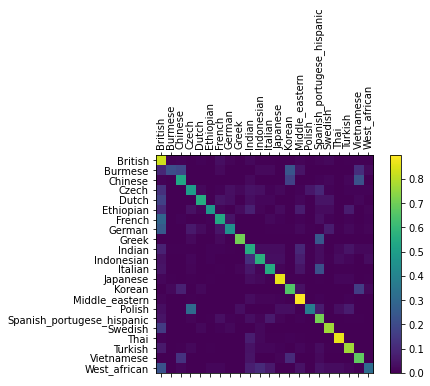

In [124]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_n.numpy())
fig.colorbar(cax)

all_categories = test_dataset.get_countries()

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [126]:
for i in range(N_COUNTRIES):
  print(all_categories[i])
  print(confusion_n[i][i])

#print(confusion_n)

British
tensor(0.8311)
Burmese
tensor(0.2143)
Chinese
tensor(0.5317)
Czech
tensor(0.4956)
Dutch
tensor(0.5556)
Ethiopian
tensor(0.4800)
French
tensor(0.5421)
German
tensor(0.4540)
Greek
tensor(0.7073)
Indian
tensor(0.5550)
Indonesian
tensor(0.5700)
Italian
tensor(0.5510)
Japanese
tensor(0.8663)
Korean
tensor(0.6531)
Middle_eastern
tensor(0.8972)
Polish
tensor(0.3793)
Spanish_portugese_hispanic
tensor(0.7108)
Swedish
tensor(0.7708)
Thai
tensor(0.8691)
Turkish
tensor(0.7681)
Vietnamese
tensor(0.6786)
West_african
tensor(0.3182)
